In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate


from pygsp import graphs, filters, plotting
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
import scipy
import matplotlib
import utils



import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import time

from sklearn.metrics import classification_report

In [3]:
gcn_message = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [4]:
# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [5]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs.float())
        h = th.relu(h)
        m = nn.Dropout(p=0.2)
        h = m(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 30 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.

In [6]:
# TRAINING / evaluating

def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features).float()
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask, report=False):
    model.eval()  # Deactivate dropout
    with th.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
#         print(indices, labels)
        correct = th.sum(indices == labels)
        if report == True:
            return correct.item() * 1.0 / len(labels), classification_report(labels, indices)
        return correct.item() * 1.0 / len(labels)
    

In [7]:
# Build the target
# genotype_gene_expression_present_df = pd.read_pickle("data/pickle/genotype_gene_expression_present_df.pkl")
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')

In [8]:
# Build the relevant high variance signals
gene_expression_df = pd.read_pickle("data/pickle/concat_gene_expression.pkl")

In [9]:
gene_expr = gene_expression_df.copy(deep=True)
gene_expr = gene_expr.loc[:, gene_expr.isna().sum(axis=0) < 30]
gene_expr = gene_expr.loc[y.index]
top_var = 25
# top_var_gene = gene_expr.std().sort_values()
top_var_gene = gene_expr.std().sort_values().tail(top_var)

In [10]:
signal = gene_expression_df.copy(deep=True)
signal = signal.loc[:, top_var_gene.index]
signal = signal.groupby(by=signal.columns, axis=1).mean()

In [11]:
signal.shape

(94, 17)

In [12]:
# What are the most present labels ?
y.value_counts()

1    30
2    23
4    19
3    18
Name: X62, dtype: int64

# Two classes evaluation

In [13]:
# Select only the mice that have label 1 or 2. We chose it because they are the most present
y_binary = y.copy(deep=True)
y_binary = y_binary.loc[(y.values == 1) | (y.values == 2)]

In [14]:
# Drop the rows with only nan values
sign = signal.copy(deep=True)
sign = sign.loc[y_binary.index]
sign.fillna(sign.mean(), inplace=True)

In [15]:
# Filter y_binary to take into account nan filtering
y_binary = y_binary.loc[sign.index]

In [16]:
# Are both index the same ?
(y_binary.index == sign.index).all()

True

In [17]:
# Transfrom to np.array
sign_np = sign.values
y_b = y_binary.values

In [18]:
# Build the training/testing data
features = th.tensor(sign_np)
labels = th.tensor(y_b)

In [20]:
# Restart classes from 0
labels[labels == 1] = 0
labels[labels == 2] = 1

In [211]:
# Split the data into train / test / validation
test_p = 0.25
val_p = 0.25
test_size = int(len(labels)*test_p)
val_size = int((len(labels) - test_size) * val_p)
random_idx = th.randperm(len(labels))
not_test_mask = random_idx[test_size:]


# Test mask
test_mask = random_idx[:test_size]

# Train masks
train_random_idx = th.randperm(len(not_test_mask))
train_mask = not_test_mask[train_random_idx[val_size:]]
val_mask = not_test_mask[train_random_idx[:val_size]]


print("train_size: %i | test_size: %i | val_size: %i" % (len(labels) - test_size - val_size, test_size, val_size))

train_size: 30 | test_size: 13 | val_size: 10


In [212]:
# Build a graph adjacency for the subsample and mice labeled as 1 and 4
genotype_df = pd.read_pickle('data/pickle/genotype_df.pkl')
adj = utils.build_adj_from_strain(genotype_df, sign.index, 'cosine', 70, 0.266)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


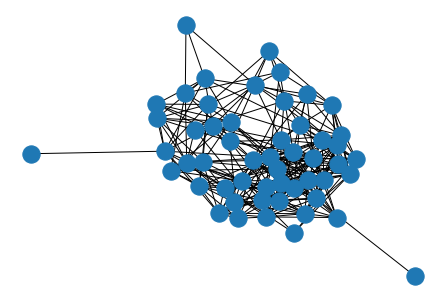

In [213]:
nx.draw(nx.from_numpy_array(adj))

In [214]:
utils.graph_basic_stats(nx.from_numpy_array(adj))

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  53    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 311    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  22.57 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │  11.74 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.39 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   4    │
╘═════════════════════════════════════════════════╧════════╛


In [127]:
graph = DGLGraph(adj)

In [128]:
model = GCN(sign_np.shape[1], 5, 2)

In [129]:
pol_order = 3
lr = 0.5
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.2

In [130]:
loss_fcn = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(),\
                          lr=lr, weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)
    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc, report = evaluate(model, graph, features, labels, test_mask, report=True)
print("Test Accuracy {:.4f}".format(acc))
print(report)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 373.2446 | Val Accuracy 0.2000
Epoch 00001 | Time(s) nan | Train Loss 0.7418 | Val Accuracy 0.2000
Epoch 00002 | Time(s) nan | Train Loss 0.8221 | Val Accuracy 0.2000
Epoch 00003 | Time(s) 0.0153 | Train Loss 0.8196 | Val Accuracy 0.2000
Epoch 00004 | Time(s) 0.0163 | Train Loss 0.7669 | Val Accuracy 0.2000
Epoch 00005 | Time(s) 0.0162 | Train Loss 0.7133 | Val Accuracy 0.8000
Epoch 00006 | Time(s) 0.0158 | Train Loss 0.6910 | Val Accuracy 0.8000
Epoch 00007 | Time(s) 0.0150 | Train Loss 0.7034 | Val Accuracy 0.8000
Epoch 00008 | Time(s) 0.0150 | Train Loss 0.7294 | Val Accuracy 0.8000
Epoch 00009 | Time(s) 0.0151 | Train Loss 0.7461 | Val Accuracy 0.8000
Epoch 00010 | Time(s) 0.0147 | Train Loss 0.7436 | Val Accuracy 0.8000
Epoch 00011 | Time(s) 0.0148 | Train Loss 0.7263 | Val Accuracy 0.8000
Epoch 00012 | Time(s) 0.0143 | Train Loss 0.7054 | Val Accuracy 0.8000
Epoch 00013 | Time(s) 0.0140 | Train Loss 0.6925 | Val Accuracy 0.8000
Epoch 00014 |

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
labels[test_mask]

tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0])

Eventhough the result seems to be good, the data is unbalanced so the prediction is highly biased towards the 0 class

# Four classes evaluation

In [422]:
# Select all classes of mouse
y_fourC = y.copy(deep=True)

In [431]:
signal

gene,AI594671_1449603_at,AI594671_1449603_at,Pnliprp2_10464328,Pnliprp2_10464328,Mtmr7_1447831_s_at,Mtmr7_1447831_s_at,Serpina1b_10402390,Serpina1b_10402390,LOC674190_10403011,LOC674190_10403011,...,Amy2a1_10501500,Amy2a1_10501500,Amy2a1_10501511,Amy2a1_10501511,Amy2a1_10501522,Amy2a1_10501522,Amy2a1_10501533,Amy2a1_10501533,Amy2a1_10501494,Amy2a1_10501494
BXD1,4.408,5.234,7.103,6.914,9.538,9.321,8.322,8.911,8.736,9.960,...,6.595,5.936,6.595,5.936,6.595,5.936,6.595,5.936,5.257,4.923
BXD2,4.553,5.239,9.903,11.682,9.837,9.728,7.187,8.051,8.807,8.889,...,14.114,14.767,14.114,14.767,14.114,14.767,14.114,14.767,13.344,14.127
BXD5,5.538,8.939,6.879,8.151,9.450,9.734,7.687,8.383,8.498,9.250,...,6.187,12.048,6.187,12.048,6.187,12.048,6.187,12.048,5.588,11.428
BXD6,4.462,4.962,11.683,6.877,9.597,9.992,11.620,12.108,5.446,5.536,...,14.480,10.024,14.480,10.024,14.480,10.024,14.480,10.024,13.723,9.327
BXD8,4.485,4.984,9.242,6.940,9.902,9.603,10.191,12.085,7.288,8.445,...,10.070,6.524,10.070,6.524,10.070,6.524,10.070,6.524,9.358,6.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BXD98,4.483,6.230,7.271,11.310,9.545,9.956,8.238,7.993,10.566,9.011,...,11.044,14.501,11.044,14.501,11.044,14.501,11.044,14.501,10.554,13.799
BXD99,6.673,8.522,11.487,11.399,6.469,6.216,8.607,8.569,9.240,9.627,...,14.408,14.369,14.408,14.369,14.408,14.369,14.408,14.369,13.863,13.951
BXD100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD101,NaN,NaN,11.293,7.397,NaN,NaN,11.966,11.656,8.196,7.816,...,14.428,7.872,14.428,7.872,14.428,7.872,14.428,7.872,13.680,7.018


In [433]:
# Drop the rows with only nan values
sign = signal.loc[y_fourC.index].copy(deep=True)

In [434]:
sign.shape

(90, 199)

In [314]:
shape = []
for i in range(1000):
    shape.append(sign.dropna(thresh=i).shape[0])

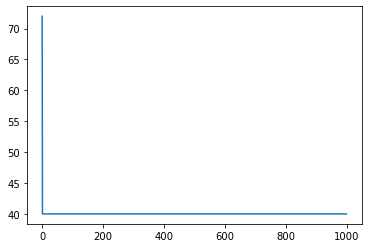

In [315]:
plt.plot(shape)

In [289]:
# Filter y_binary to take into account nan filtering
y_fourC = y_fourC[y_fourC.index.isin(sign.index)]

In [290]:
# Are both index the same ?
(y_fourC.index == sign.index).all()

True

In [291]:
# Transfrom to np.array
sign_np = sign.values

In [292]:
# Transfrom to np.array
sign_np = sign.values
y_f = y_fourC.values

In [293]:
sign_np.shape

(40, 10000)

In [202]:
# Build the training/testing data
features = th.tensor(sign_np)
labels = th.tensor(y_b)